# Creating Our Own Spectrogram

In this notebook we will learn how to create our own *spectrogram*. A spectrogram is a visual representation of the frequencies in a signal (such as an audio signal) *as they vary in time*. That is, whereas plotting the Fourier components (i.e. the Fourier spectrum) of a signal tells us what frequencies are present in the signal, a spectrogram will tell us what frequencies are present in the signal and *where/when* they occur. This is an extremely powerful tool for signal analysis.

To complete this notebook, you will need to install:
- [Microphone](https://github.com/LLCogWorks2018/Microphone)
- [MyGrad](https://github.com/rsokl/MyGrad)

In [33]:
# run this cell (maybe twice to get %matplotlib notebook to work)
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt


import matplotlib.mlab as mlab
from microphone import record_audio

## Accessing Time *and* Frequency: Building an Intuition for Spectrograms

Thus far we have seen two means for representing audio data visually. We have plotted:
1. Amplitude vs Time: Shows how the pressure from the sound wave varies over time.
2. Fourier Spectrum: Reveals the prominent frequencies that are present in the sound wave.

Let's revisit the clip of a trumpet playing a chord that we studied before.

In [19]:
# running this cell loads the PCM-encoded data for the trumpet clip
with open("data/trumpet.txt", 'r') as R:
    trumpet_audio = np.asarray([int(i) for i in R])
    
sampling_rate = 44100 # sampling rate in Hz

Let's play this audio clip to recall what is being played.

In [5]:
from IPython.display import Audio
Audio(trumpet_audio, rate=sampling_rate)

We'll plot both the amplitude/time wave form and its Fourier spectrum. We will plot the Fourier coefficients, $|c_{k}|$, on a *log-scale*. This is a natural scale to plot the Fourier spectrum on, as the human ear responds to loudness on a logarithmic scale (an amplitude of  4 needs to increase to an amplitude of 16 ($4^2$) in order for us to perceive a doubling in loudness).

<IPython.core.display.Javascript object>


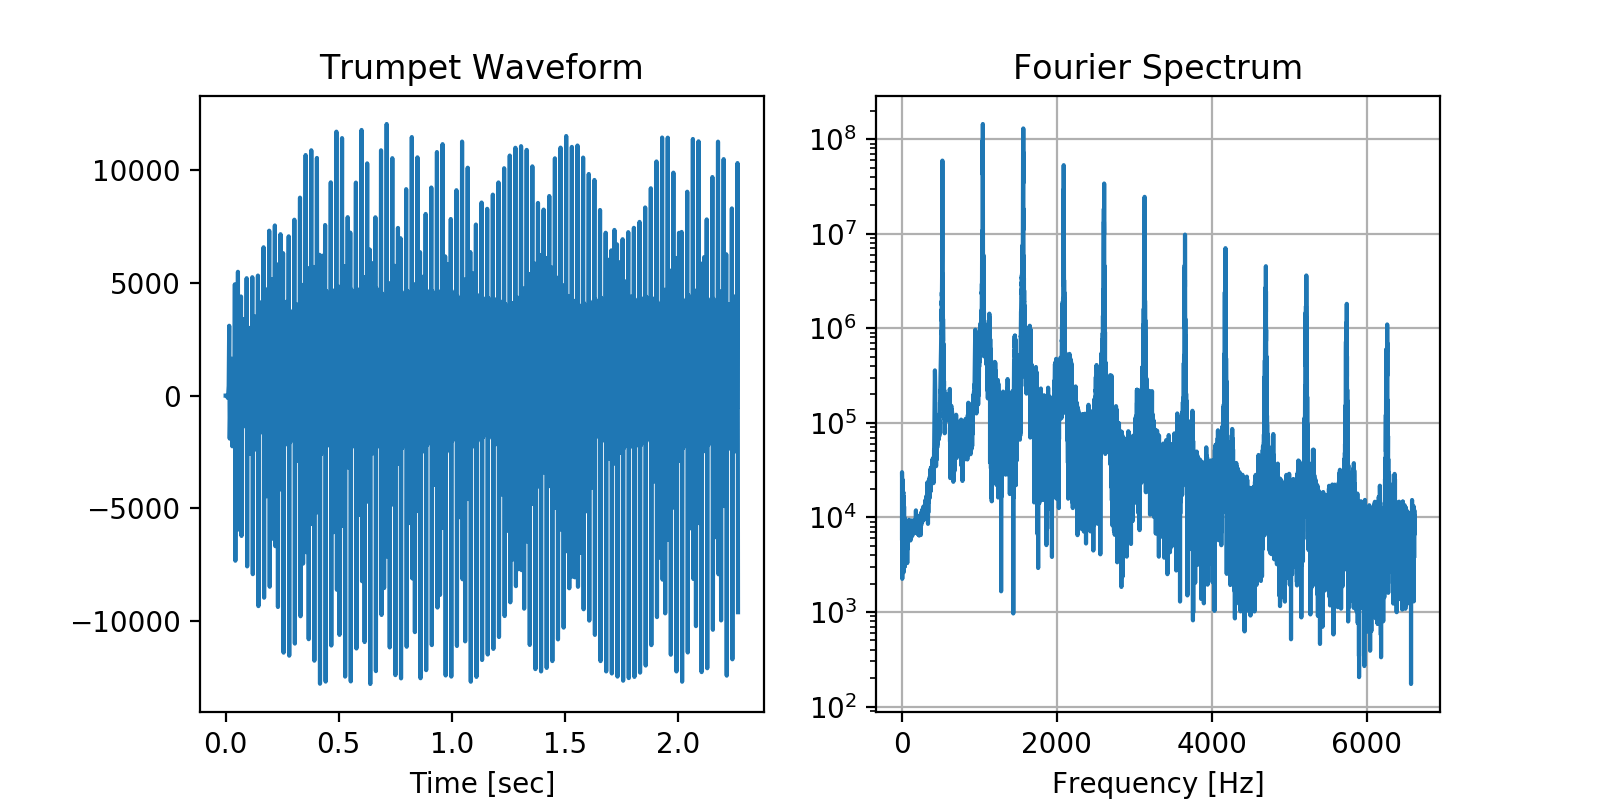

In [28]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8,4))

# compute the time at which each sample was recorded (sec)
time = np.arange(len(trumpet_audio)) / sampling_rate

# Plotting the waveform
ax0.plot(time[::100], trumpet_audio[::100]) # plot every 100th point in the waveform
ax0.set_xlabel("Time [sec]")
ax0.set_title("Trumpet Waveform")

# Plotting the Fourier spectrum
T = len(trumpet_audio) / sampling_rate # total time-span of audio clip

ck =  np.fft.rfft(trumpet_audio)  # complex-valued Fourier coefficients
spectrum = np.abs(ck) # we only care about |ck|: the magnitudes of the coefficients

# convert k = 0, 1, ... to freq = 0, 1/T, 2/T, ....
freq = np.arange(len(ck)) / T

ax1.plot(k[:15000], spectrum[:15000])
ax1.set_title("Fourier Spectrum")
ax1.set_xlabel("Frequency [Hz]")
ax1.grid(True)
ax1.set_yscale("log");

See that there is a trade-off between these two representations of the data. That is, from the waveform we can see that the trumpet is playing a relatively sustained chord for about 2.5 seconds. That being said, we cannot glean what the audio would sound like; i.e. what notes are being played. The Fourier spectrum reveals very clear information about the notes being played, but reveals nothing about the duration or ordering of the notes (are they being played in unison? in sequence? for how long? etc.).

We would like to know *what frequencies* are present in our signal and *when* they occur in our signal. A **spectrogram** plots exactly this information. Without further adieu, let's use matplotlib's built-in spectrogram function to understand what this visualization represents:



<IPython.core.display.Javascript object>


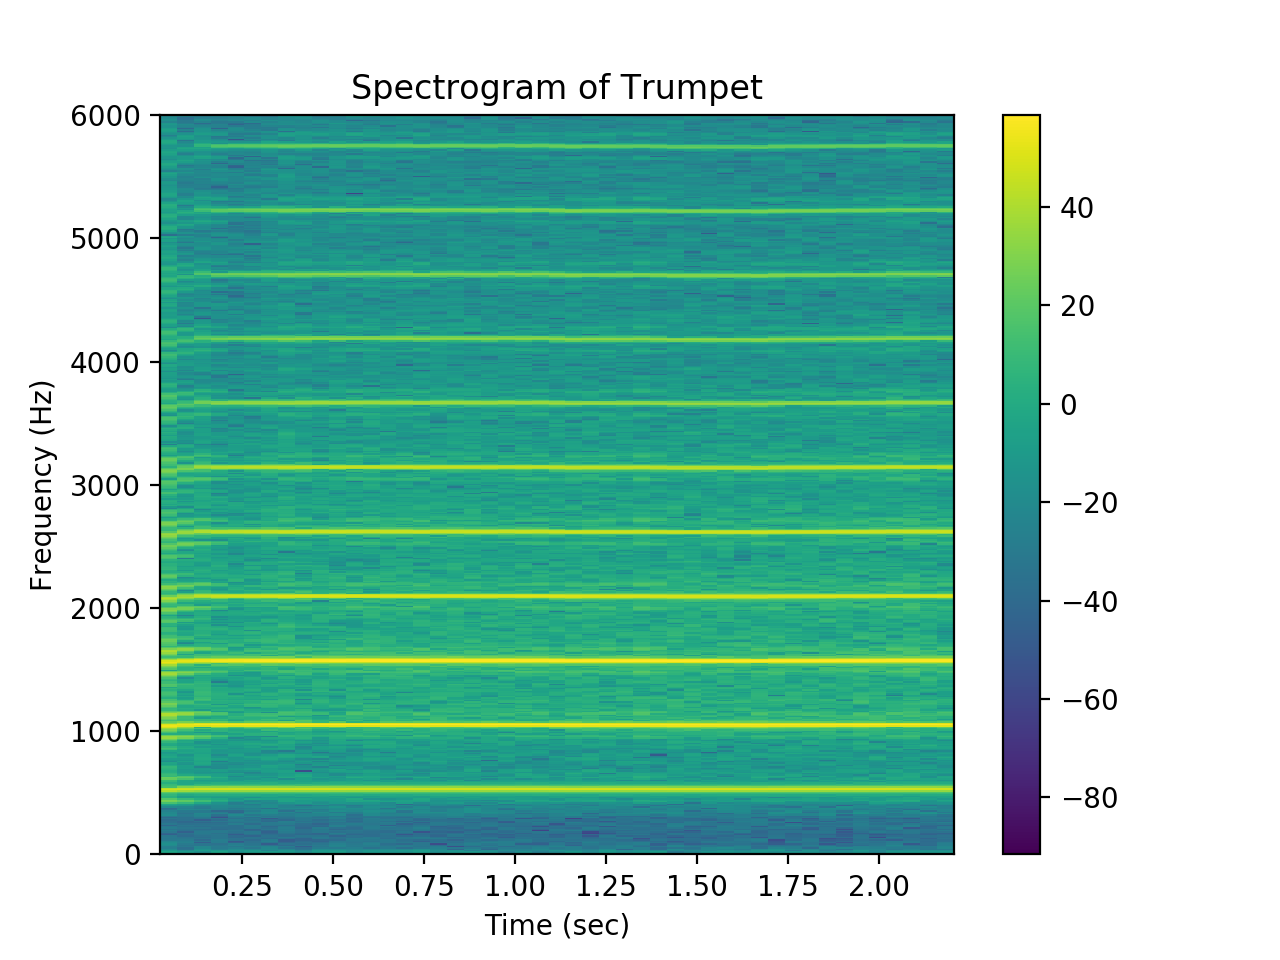

In [31]:
# using matplotlib's built-in spectrogram function
fig, ax = plt.subplots()

S, freqs, times, im = ax.specgram(trumpet_audio, NFFT=4096, Fs=sampling_rate,
                                  window=mlab.window_hanning,
                                  noverlap=4096 // 2)
fig.colorbar(im)

ax.set_xlabel("Time (sec)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Spectrogram of Trumpet")
ax.set_ylim(0, 6000);

The spectrogram displays a heat map which reflects the magnitude (i.e. absolute value) of the Fourier coefficients for a given time and frequency. For example the yellow horizontal streak near 1000 Hz indicates that this frequency is prominent throughout the duration of the signal. Note that this spectrogram function is automatically plotting these magnitudes on a log-scale, for the reasons discussed above. This plot reveals that the prominent notes are being played in unison, and sustained for roughly 2.5 seconds. We can also easily read off the frequencies of these notes.

Use `mlab.specgram`, as used to generate the plot above, and `from microphone import record_audio` and create a function that:

- accepts a time-length, in seconds 
- records audio for that duration of time
- plots the spectrogram for that recording 
- returns the matplotlib Figure and Axes object instances that were produced by the plot

Set the y-limit to only plot up to 6,000 Hz. Don't change any of the spectrogram settings other than the data that you pass in and the sampling rate.

In [39]:
# SOLUTION
def plot_recording(time):
    """ 
    Record audio and plot its spectrogram.
    
    Parameters
    ----------
    time : float
        The duration to record audio for
    
    Returns
    -------
    fig, ax
        The plot objects for the spectrogram"""
    frames, sample_rate = record_audio(time)
    data = np.hstack([np.frombuffer(i, np.int16) for i in frames])

    # using matplotlib's built-in spectrogram function
    fig, ax = plt.subplots()

    S, freqs, times, im = ax.specgram(data, NFFT=4096, Fs=sampling_rate,
                                      window=mlab.window_hanning,
                                      noverlap=4096 // 2)
    ax.set_ylim(0, 6000)
    ax.set_xlabel("time (sec)")
    ax.set_ylabel("frequency (Hz)")
    return fig, ax

To continue building our intuition for the spectrogram, use `microphone.record_audio` to record a 5 second clip of yourself whistling, clapping, etc. Try varying the pitch, rhythm, etc. during the clip. Plot the clip as a spectrogram. 

<IPython.core.display.Javascript object>


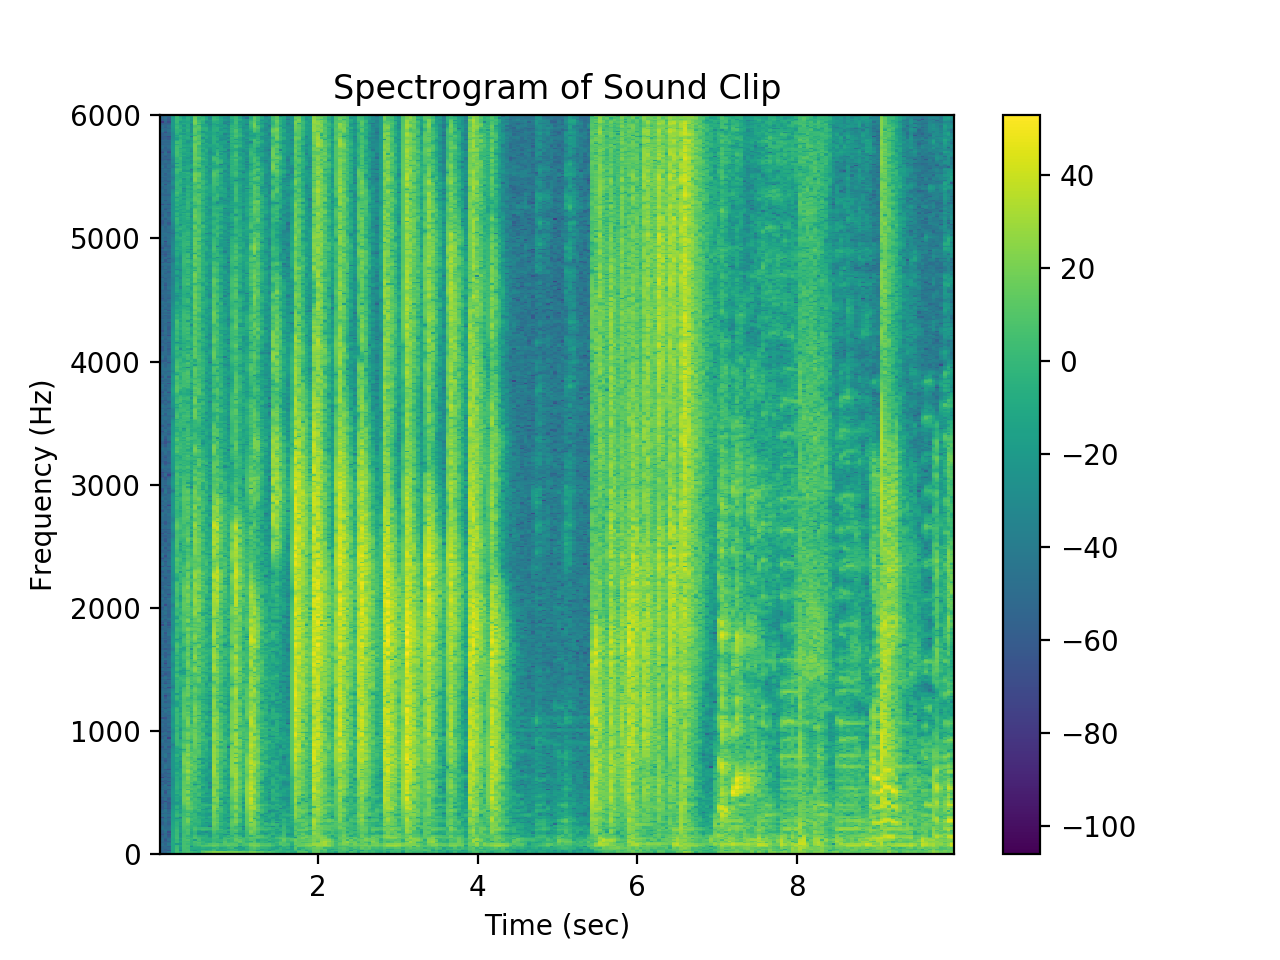

In [34]:
# SOLUTION
plot_recording(5);

You should see that the spectrogram successfully captures both the prominent frequencies present in the signal and their dynamics in time. This is extremely useful! Now how exactly is this working?

## Digging into Spectrograms

A spectrogram is constructed simply by dividing your signal into windows of time-length $\Delta t$: 

\begin{equation}
signal \Longrightarrow
\begin{bmatrix}
    \leftarrow   &  signal_{\Delta t_{0}} & \rightarrow  \\
    \leftarrow   &  signal_{\Delta t_{1}}  \\
    & \cdots  &\\
    \leftarrow   &  signal_{\Delta t_{N-1}} & \rightarrow  \\
\end{bmatrix}
\end{equation}

and performing a Fourier transform on each window of the signal. This produces a frequency spectrum for each time bin of size $\Delta t$; this makes up each column of numbers in the spectrogram:

\begin{equation}
\begin{bmatrix}
    \leftarrow   &  signal_{\Delta t_{0}} & \rightarrow  \\
    \leftarrow   &  signal_{\Delta t_{1}}  \\
    & \cdots  &\\
    \leftarrow   &  signal_{\Delta t_{N-1}} & \rightarrow  \\
\end{bmatrix} \Longrightarrow 
\begin{bmatrix}
    \leftarrow   &  \{\|c_{k}\|\}_{\Delta t_{0}} & \rightarrow  \\
    \leftarrow   &  \{\|c_{k}\|\}_{\Delta t_{1}}  \\
    & \cdots  &\\
    \leftarrow   &  \{\|c_{k}\|\}_{\Delta t_{N-1}} & \rightarrow  \\
\end{bmatrix} 
\end{equation}



If each window of our signal contains $M$ points, then the Fourier transform on each bin will produce $\lfloor\frac{M}{2}\rfloor + 1$ Fourier amplitude coefficients $\{\|c_{k}\|\}$ (we are interested in the *magnitude* of each coefficient, not its complex value). This allows us to know what the frequency distribution is in our signal during each interval $[n\Delta t, (n+1)\Delta t]$, $n \in \mathbb{N}$.

The *transpose* of the depicted array is what we plot in the spectrogram: each column is the Fourier component amplitudes for that window of the signal.


The following function produces the same spectrogram as was plotted above, but without producing the associated plot; let's get the spectrogram for the trumpet wave form:

In [24]:
# obtaining the spectrogram for the trumpet wave form (again)
with open("data/trumpet.txt", 'r') as R:
    trumpet_audio = np.asarray([int(i) for i in R])
    
sampling_rate = 44100 # sampling rate in Hz

S, freqs, times = mlab.specgram(trumpet_audio, NFFT=4096, Fs=sampling_rate,
                                window=mlab.window_hanning,
                                noverlap=int(4096 / 2))

`S` is the spectrogram, the 2D array whose rows corresponds to frequencies and whose columns correspond to time. `freqs` is an array of the frequency values corresponding to the rows, and `times` is an array of time values corresponding to the columns.

How many time bins were used in the spectrogram? How many frequincy values? Verify that the shape of `S` corresponds with the lengths of `freqs` and `times`.

In [37]:
# SOLUTION

# S.shape is (2049, 47), thus there are 47 time bins and 2049 frequencies represented.
assert S.shape == (len(freqs), len(times))

What are the sizes of the frequency bins? Of the time bins? Are the bins uniform in size?

In [47]:
# SOLUTION
df = set(np.diff(freqs))
dt = set(np.diff(times))

SOLUTION
> A constant frequency bin size ($\Delta f$) 10.766 Hz is used. A (nearly) constant time bin size ($\Delta t$) of 0.0464s is used.

## Creating Your Own Spectrogram

`mygrad` comes with a sliding window function; this creates windowed *views* of an array at regular intervals. Import `sliding_window_view` from `mygrad`. Now create an array containing the integers from 0 to 11. Use `sliding_window_view` to make the following windowed views:
- window size: 2, stride: 1
- window size: 2, stride: 2
- window size: 3, stride: 2
- window size: 6, stride: 3
- window size: 6, stride: 6

Note that `sliding_window_view` doesn't accept a window *size* but rather a window *shape*. Thus if you want to make a 1D window of size 2, you would specify `window_shape=(2,)`. Study the shape and contents of the windowed arrays that you produce here. What do the axes of the resulting array correspond to? Use `numpy.shares_memory` to convince yourself that these arrays do not make a copy of the underlying data. Discuss your observations with your neighbor.

In [ ]:
# YOUR WORK HERE

> SOLUTION: A row of the array stores a single window of the data. The number of rows is thus the number of windows formed. The number of columns is the length of each window. 

Now use `sliding_window_view` to create **non-overlapping** time windows of the trumpet audio signal. Determine the appropriate window size so as to roughly match the spectrogram that we created above. That is, make sure that your $\Delta t$ matches theirs.

In [27]:
# SOLUTION
# dt is ~= 0.0464 sec for the matplotlib spectrogram
window_size = int(0.0464 * 44100)
windowed_trumpet = sliding_window_view(trumpet_audio, window_shape=(window_size,), step=window_size)

Look at the shape of your array. How many time windows did you create? How many samples reside in each window? Thus what is the time duration of each window?

Now take the discrete Fourier transform, using `np.fft.rfft`,  over each time window. Note that `np.fft.rfft` accepts an axis argument, thus you can vectorize this operation instead of using for-loops. Take the absolute value of the output to convert the complex-values Fourier coefficients into real-valued magnitudes.

Do the rows and columns of the array that you have just computed correspond to what we want for our spectrogram? That is, do our rows correspond to frequencies, and columns correspond to times? Update your array so that they do.

In [29]:
# SOLUTION
spectrogram = np.absolute(np.fft.rfft(windowed_trumpet, axis=-1)).T

Compute the duration of the trumpet signal, given that the sampling rate used to record it was 44100 Hz. Assign this to `T`.

In [30]:
# SOLUTION
T = len(trumpet_audio) / 44100

Compute the maximum frequency included by Fourier components. Assign this to `F`

In [31]:
# SOLUTION
F = (len(trumpet_audio)//2 + 1) / T

Time to plot our spectrogram! We will make use of `T` and `F` to set the scales for our plot axes, and to set a sensible aspect ratio for the plot.

<IPython.core.display.Javascript object>


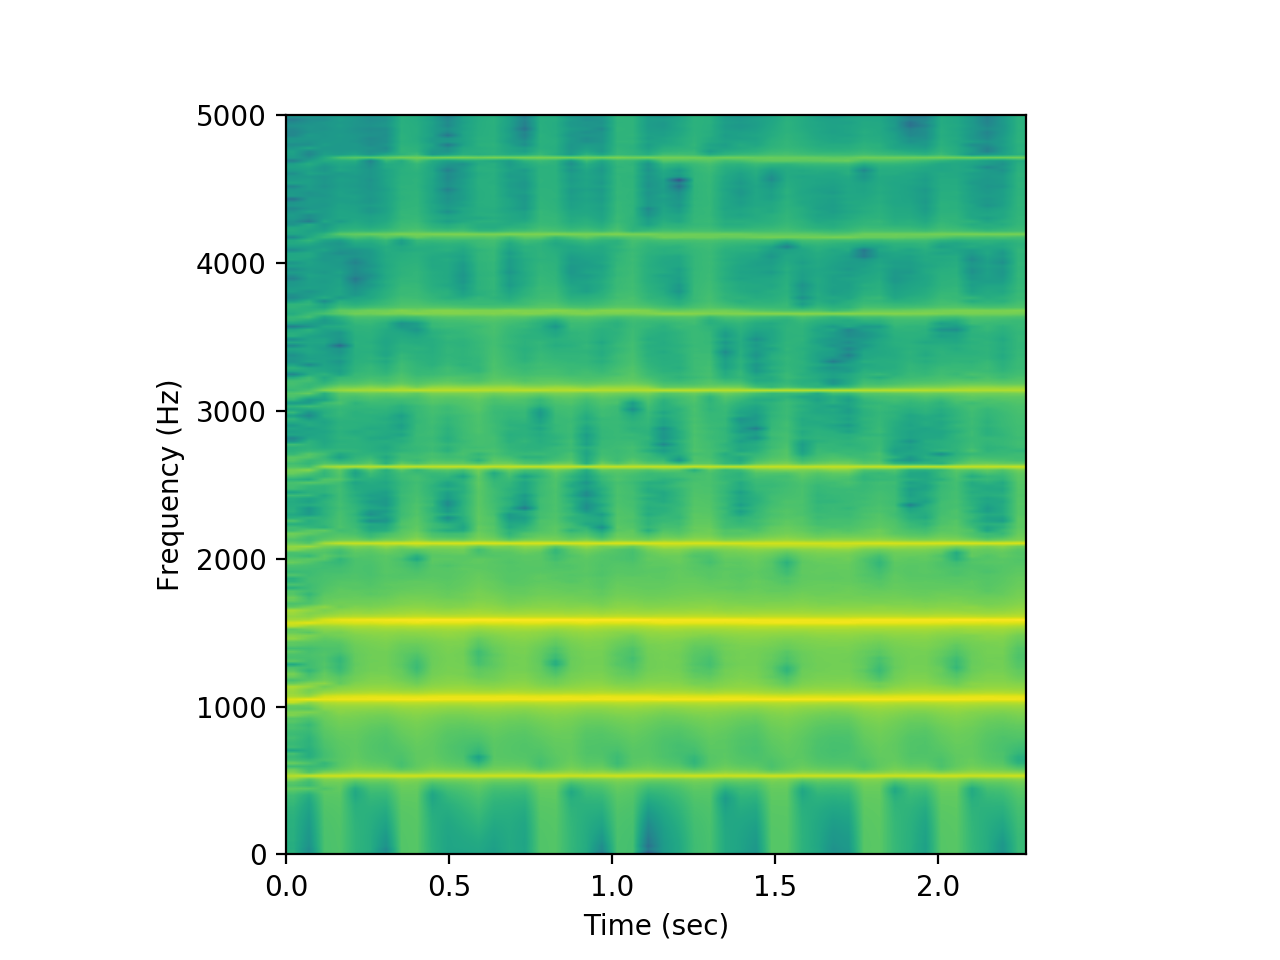

In [35]:
# Plug your spectrogram array in `imshow` and execute this cell
# notes that we set `origin="lower"` in the `imshow function, this is
# so the low frequencies occur at the bottom of the y axis; this is flipped
# from how your array is structured

max_freq = 5000 # the largest frequency that we want to plot
extent = (0, T, 0, F)  # this is used to set the (left, right, bottom, top) scale for the image axes
aspect_ratio = T/max_freq

fig, ax = plt.subplots()
ax.imshow(np.log(spectrogram), origin="lower", aspect=aspect_ratio, extent=extent, interpolation="bilinear")
ax.set_ylim(0, max_freq)

ax.set_xlabel("Time (sec)")
ax.set_ylabel("Frequency (Hz)");

You may see a purple background with sharp horizontal lines. To mimic the original spectrogram plot, you should plot the *log* of the fourier amplitudes.

This plot should resemble that of the original spectrogram quite closely. There are some special considerations to take in order to ensure that the boundaries between time bins are handled well - not accounting for these introduces significant artifacts into the spectrogram. At its core, a spectrogram is as simple as applying a Fourier transform on time-windowed bins of the signal, and plotting the resulting Fourier coefficient amplitudes as the columns of a frequency vs time plot, with each column corresponding to a time window of the signal.

- col-0 : Fourier transform of signal during $\Delta t_0$ 
- col-1 : Fourier transform of signal during $\Delta t_1$ 
- ... 

To improve the quality of your spectrogram, you can try doubling the window size, but keeping the same stride. Thus the windows will partially overlap, which will help to mitigate the effects of the artificial boundaries that we introduced in our windowing. 